# Translating Story Map from one language to another using Deep Learning

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
<li><span><a href="#Prerequisites" data-toc-modified-id="Prerequisites-2">Prerequisites</a></span></li>
<li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li>
<li><span><a href="#Translate-Story-Map-from-English-to-Spanish" data-toc-modified-id="Translate-Story-Map-from-English-to-Spanish-4">Translate Story Map from English to Spanish</a></span></li>
<ul class="toc-item">
    <li><span><a href="#Connect-to-GIS-and-clone-Story-Map" data-toc-modified-id="Connect-to-GIS-and-clone-Story-Map-4.1">Connect to GIS and clone Story Map</a></span></li>
    <li><span><a href="#Instantiate-text-translator" data-toc-modified-id="Instantiate-text-translator-4.2">Instantiate text translator</a></span></li>
    <li><span><a href="#Translate-Story-Map-content" data-toc-modified-id="Translate-Story-Map-content-4.3">Translate Story Map content</a></span></li>
    <li><span><a href="#Update-cloned-Story-Map-item" data-toc-modified-id="Update-cloned-Story-Map-item-4.4">Update cloned Story Map item</a></span></li>
</ul>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5">Conclusion</a></span></li>    
<li><span><a href="#References" data-toc-modified-id="References-6">References</a></span></li>
</ul>
</div>

# Introduction

A [story map](https://www.esri.com/en-us/arcgis/products/arcgis-storymaps/overview) is a web map that is created for a given context with supporting information so that it becomes a stand-alone resource. It integrates maps, legends, text, photos, and video. Story maps can be built using Esri's story map templates and are a great way to quickly build useful information products tailored to one's organization needs. Using the templates, one can publish a story map without writing any code. One can simply create a web map, supply the text and images for the story, and configure the template files to create a story map. 

Sometimes, there is a need to convert the text of a story map from one language to another so that it can be understood by nonnative language speaker as well. This can be done either by employing a human translator or by using a machine translation system to automatically convert the text from one language to another.

Machine translation is a sub-field of computational linguistics that deals with the problem of translating an input text or speech from one language to another. With the recent advancements in **Natural Language Processing (NLP)** and **Deep Learning**, it is now possible for a machine translation system to reach human like performance in translating a text from one language to another.

In this notebook, we will pick a story map written in English language, and create another story map with the text translated to Spanish language using the `arcgis.learn.text`'s **TextTranslator** class. The **TextTranslator** class is part of inference-only classes offerered by the `arcgis.learn.text` submodule. These inference-only classes offer a simple API dedicated to several **Natural Language Processing (NLP)** tasks including **Masked Language Modeling**, **Text Generation**, **Sentiment Analysis**, **Summarization**, **Machine Translation** and **Question Answering**.

# Prerequisites

- Inferencing workflows for Inference-only Text models of `arcgis.learn.text` submodule is based on [Hugging Face Transformers](https://huggingface.co/transformers/v3.0.2/index.html) library. 
- Refer to the section [Install deep learning dependencies of arcgis.learn module](https://developers.arcgis.com/python/guide/install-and-set-up/#Install-deep-learning-dependencies) for detailed explanation about deep learning dependencies.
- [Beautiful Soup](https://anaconda.org/anaconda/beautifulsoup4) python library to pull text out from the HTML content of the story map.
- **Choosing a pretrained model**: Depending on the task and the language of the input text, user might need to choose an appropriate transformer backbone to generate desired inference. This [link](https://huggingface.co/models?search=helsinki) lists out all the pretrained models offered by [Hugging Face Transformers](https://huggingface.co/transformers/v3.0.2/index.html) library that allows translation from a source language to one or more target languages.

# Imports

In [1]:
from arcgis import GIS
from bs4 import BeautifulSoup
from arcgis.learn.text import TextTranslator

# Translate Story Map from English to Spanish

In this notebook we have picked up a story map written in **English** language, which talks about the near-term interim improvements (for the new bicycle and pedestrian bridge design over Lady Bird Lake) to South Pleasant Valley Road. Our goal will be to create a clone of this story map with the text translated to **Spanish** language

## Connect to GIS and clone Story Map

To achieve our goal, we will first connect to an ArcGIS online account, get the desired content by passing the appropriate item-id and cloning the item into our GIS account. We will then apply the `TextTranslator` model of `arcgis.learn.text` submodule to this cloned item to convert the content of the story map to **Spanish** language.

In [2]:
agol = GIS()

gis = GIS('home')

In [3]:
storymapitem = agol.content.get('c8eef2a96c88489c92010a63d0944881')
storymapitem

<Item title:"South Pleasant Valley Road" type:StoryMap owner:ATD_Publisher>

In [4]:
cloned_items = gis.content.clone_items([storymapitem], search_existing_items=False)
cloned_items

[<Item title:"South Pleasant Valley Road" type:StoryMap owner:arcgis_python>]

<Item title:"South Pleasant Valley Road" type:StoryMap owner:arcgis_python>
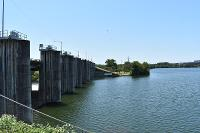

In [5]:
cloned_item = cloned_items[0]
cloned_item

In [6]:
cloned_item.id

'a5af5750f9d143238d72bac224f204fb'

## Instantiate text translator

Next, we will instantiate the class object for the `TextTranslator` model. We wish to translate text from **English** language into **Spanish** language. So will invoke the object by passing the corresponding ISO language codes [[1]](#References) in the model constructor.

In [7]:
translator = TextTranslator(source_language='en', target_language='es')

We will also write some helper functions to help translate the content of story map into the desired language. The `replace` function is a recursive [[2]](#References) function that accepts a json (story map item dictionary) object `obj` and applies the function `func` on the values `v` of the `keys` list passed in the `replace` function argument. 

In [8]:
def replace(obj, keys, func):
    return {k: replace(func(v) if k in keys else v, keys, func) 
        for k,v in obj.items()} if isinstance(obj, dict) else obj

The `translate` function will translate the English `text` (passed in the function argument) into Spanish language. The story map text sometimes contain text wrapped inside HTML [[3]](#References) tags. We will use `BeautifulSoup` library to get the non-HTML part of the input text content and use the `translator`'s `translate` method to translate the non-HTML part of the input text into desired language (Spanish in this case). 

In [9]:
def translate(text):
    if text == '': 
        return text
    
    soup = BeautifulSoup(text, "html.parser") 

    for txt in soup.find_all(text=True):
        
        translation = translator.translate(txt)[0]['translated_text'] if txt.strip() != '' else txt
        txt.string.replace_with(" " + translation + " ")
    
    return str(soup)

## Translate Story Map content

We will call the story map item's `get_data()` method to retrieves the data associated with the item.

In [10]:
smdata = storymapitem.get_data()

The call to the above method will return a python dictionary containing the contents of the story map which we wish to translate. We wish to translate not only the `text` content of the story map but also things like `title`, `summary`, `captions`, etc. To do so we will call the `replace` function defined above with the desired arguments. 

In [11]:
result = replace(smdata, ['text', 'alt', 'title', 'summary', 'byline', 'caption', 'storyLogoAlt'], translate)

## Update cloned Story Map item

This cloned story map item doesn't contain the translated version of the story map until this point. But this can be achieved by calling the `update()` method of the cloned item and passing a dictionary of the item attributes we wish to translate.

In [12]:
cloned_item.update({'url': cloned_item.url.replace(storymapitem.id, cloned_item.id), 
    'text': result,
    'title': translator.translate(storymapitem['title'])[0]['translated_text'],
    'description': translator.translate(storymapitem['description'])[0]['translated_text'],
    'snippet': translator.translate(storymapitem['snippet'])[0]['translated_text']})

True

The cloned story map text is now translated into Spanish language and is ready to be shared.

<Item title:"South Pleasant Valley Road" type:StoryMap owner:arcgis_python>
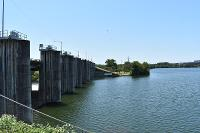

In [13]:
cloned_item

In [14]:
cloned_item.share(True)

{'results': [{'itemId': 'a5af5750f9d143238d72bac224f204fb',
   'success': True,
   'notSharedWith': []}]}

# Conclusion

This sample demonstrates how inference only `TextTranslator` class  of `arcgis.learn.text` submodule can be used to perform machine translation task to translate text from one language to another. We showed, how easy it is to translate a story map which is written in English language into Spanish language. Similar workflow can be followed to automate the task of translating story maps or other ArcGIS items into various languages. 

# References

[1] [ISO Language Codes](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes)

[2] [Recursion](https://en.wikipedia.org/wiki/Recursion_(computer_science))

[3] [HTML](https://en.wikipedia.org/wiki/HTML)